## 🧬PCOS Risk analysis and early detection for Clinical Decision Support using Personalized Integrated AI.

Polycystic Ovary Syndrome (PCOS) is a complex endocrine disorder influenced by multiple clinical, physiological, and lifestyle factors. Reliable machine learning–based PCOS risk prediction requires high-quality, well-structured datasets.

The objective of this phase is to collect, integrate, and preprocess both clinical and lifestyle datasets to ensure data consistency, reliability, and suitability for downstream machine learning tasks.

To strengthen real-world applicability, two datasets are used:

A clinical dataset for training machine learning models.

A real-time lifestyle survey dataset for external validation.

📂 Datasets Used

Training Dataset: PCOS_data_without_infertility.csv
→ Used for model training and internal validation

Testing Dataset: Real_Time_Testing.csv
→ Used for external validation and real-time prediction

🎯 Objective 1
To collect and preprocess clinical and lifestyle datasets for PCOS risk prediction


Import all the necessary libraries

In [105]:
import os
import random
import copy
import numpy as np
import pandas as pd

# Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Evaluation

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Federated Learning (Flower)

import flwr as fl

# Explainability (SHAP + LIME)

import shap
from lime.lime_tabular import LimeTabularExplainer

# Display & Style

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
sns.set(style="whitegrid")


In [106]:
# STEP 1: LOAD DATASETS

train_df = pd.read_csv("PCOS_data_without_infertility.csv")
test_df  = pd.read_csv("Real_Time_Testing.csv")

print("Training dataset shape (raw):", train_df.shape)
print("Testing dataset shape (raw):", test_df.shape)

# STEP 2: BASIC INSPECTION

print("\nTraining Dataset Info:")
print(train_df.info())

print("\nTesting Dataset Info:")
print(test_df.info())

# STEP 3: REMOVE DUPLICATES

train_df = train_df.drop_duplicates()
test_df  = test_df.drop_duplicates()

# STEP 4: CLEAN COLUMN NAMES

train_df.columns = train_df.columns.str.strip()
test_df.columns  = test_df.columns.str.strip()

# STEP 5: ENCODE CYCLE REGULARITY (ROBUST FIX)

for df in [train_df, test_df]:
    if "Cycle(R/I)" in df.columns:
        # Convert 2/4 → 0/1 if present, keep existing 0/1
        df["Cycle(R/I)"] = df["Cycle(R/I)"].replace({2: 0, 4: 1})
        df["Cycle(R/I)"] = pd.to_numeric(df["Cycle(R/I)"], errors="coerce")
        df["Cycle(R/I)"] = df["Cycle(R/I)"].fillna(0)  # conservative default

# STEP 6: ENCODE BINARY FEATURES (SURVEY-SAFE)

binary_map = {
    "Y": 1, "N": 0,
    "Yes": 1, "No": 0,
    "Maybe": 0,
    "Rare": 0,
    "None": 0,
    1: 1, 0: 0
}

binary_cols = [
    "PCOS (Y/N)",
    "Weight gain(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Hair loss(Y/N)",
    "Pimples(Y/N)",
    "Fast food (Y/N)",
    "Reg.Exercise(Y/N)",
    "Family_History_PCOS"
]

for df in [train_df, test_df]:
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].replace(binary_map)
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# STEP 7: NUMERIC CONVERSION

numeric_cols = [
    "Age (yrs)",
    "Weight (Kg)",
    "Height(Cm)",
    "BMI",
    "Cycle length(days)",
    "Hip(inch)",
    "Waist(inch)",
    "Fast_Food_Intake",
    "Stress_Level",
    "Sleep_Quality",
    "Sugar_Intake"
]

for df in [train_df, test_df]:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

# STEP 8: BMI RECALCULATION (AUTHORITATIVE)

train_df["BMI"] = train_df["Weight (Kg)"] / (train_df["Height(Cm)"] / 100) ** 2
test_df["BMI"]  = test_df["Weight (Kg)"] / (test_df["Height(Cm)"] / 100) ** 2

# STEP 9: HANDLE MISSING VALUES (NO DATA LEAKAGE)

train_median = train_df.median(numeric_only=True)

train_df = train_df.fillna(train_median)
test_df  = test_df.fillna(train_median)

# STEP 10: REMOVE CLINICALLY INVALID RECORDS (TRAINING ONLY)

train_df = train_df[
    (train_df["Age (yrs)"] >= 12) & (train_df["Age (yrs)"] <= 55) &
    (train_df["BMI"] >= 15) & (train_df["BMI"] <= 45)
]

# STEP 11: FINAL SANITY CHECK

print("\nFinal Training Shape:", train_df.shape)
print("Final Testing Shape:", test_df.shape)

print("\nMissing values in training dataset:")
print(train_df.isnull().sum())

print("\nMissing values in testing dataset:")
print(test_df.isnull().sum())

print("\n✅ Objective 1 completed successfully: datasets collected, cleaned, and harmonized.")


Training dataset shape (raw): (541, 24)
Testing dataset shape (raw): (13, 19)

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sl. No                541 non-null    int64  
 1   Patient File No.      541 non-null    int64  
 2   PCOS (Y/N)            541 non-null    int64  
 3    Age (yrs)            541 non-null    int64  
 4   Weight (Kg)           541 non-null    float64
 5   Height(Cm)            541 non-null    float64
 6   BMI                   541 non-null    float64
 7   Cycle(R/I)            541 non-null    int64  
 8   Cycle length(days)    541 non-null    int64  
 9   Hip(inch)             541 non-null    int64  
 10  Waist(inch)           541 non-null    int64  
 11  Weight gain(Y/N)      541 non-null    int64  
 12  hair growth(Y/N)      541 non-null    int64  
 13  Skin darkening (Y/N)  5

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


🎯 Objective 2
Data Normalisation and Hybrid Metaheuristic Optimisation for Feature Selection

Exploratory Data analysis(EDA)

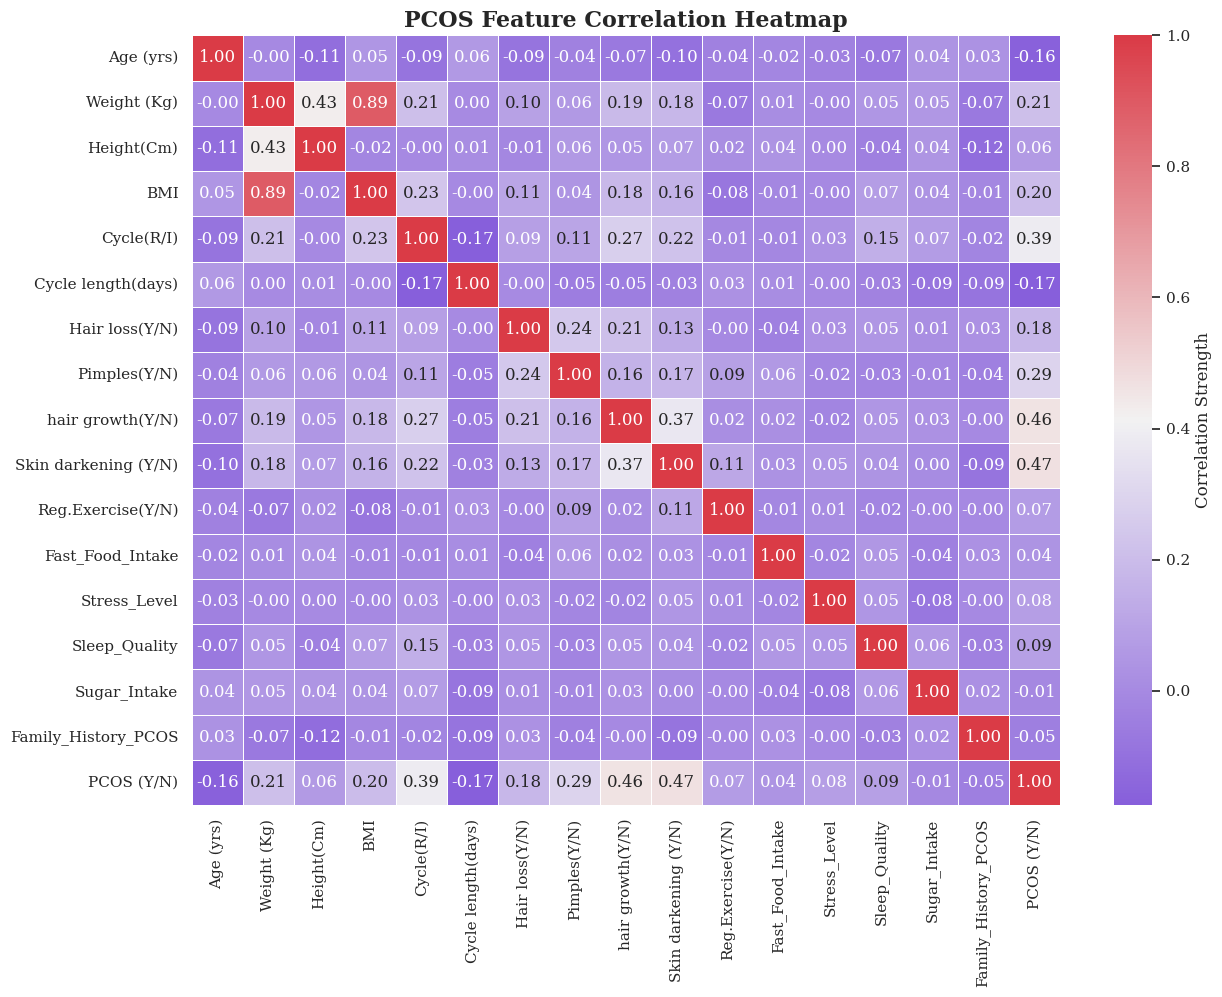



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



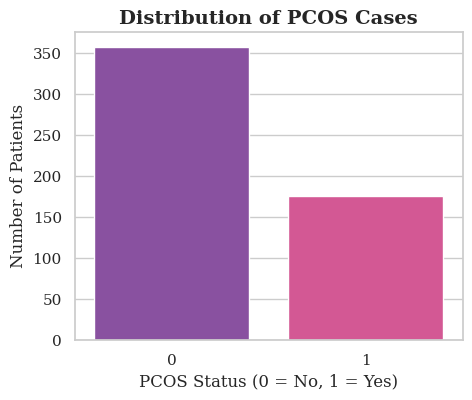

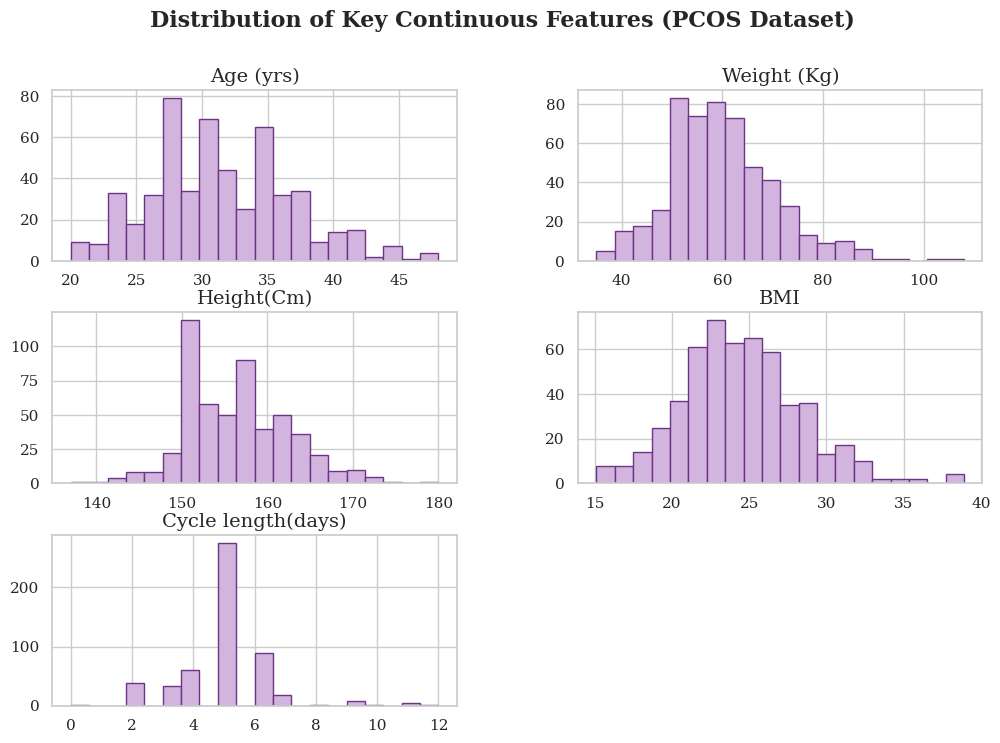


The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.


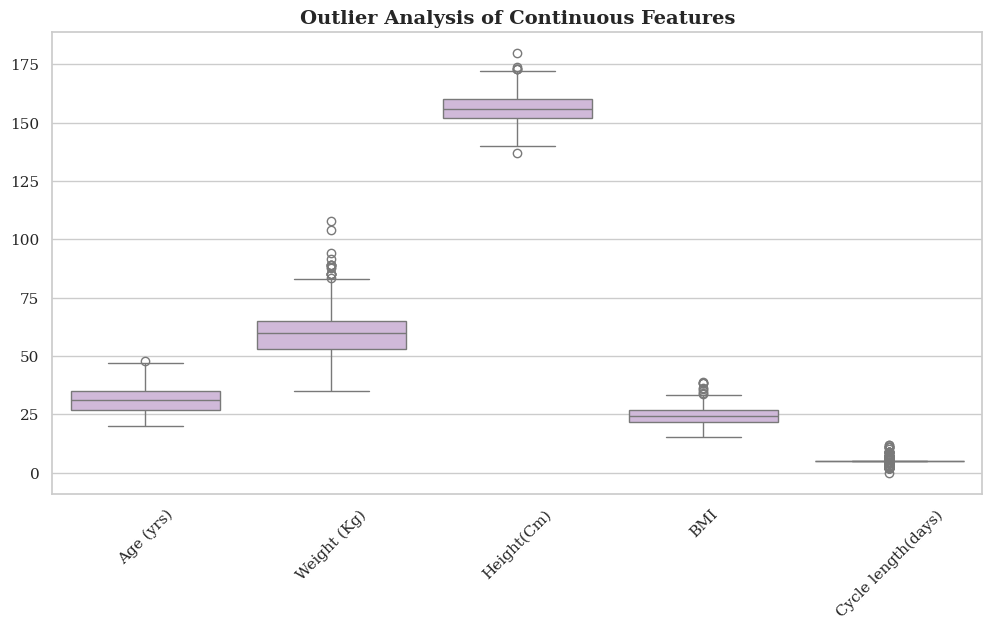

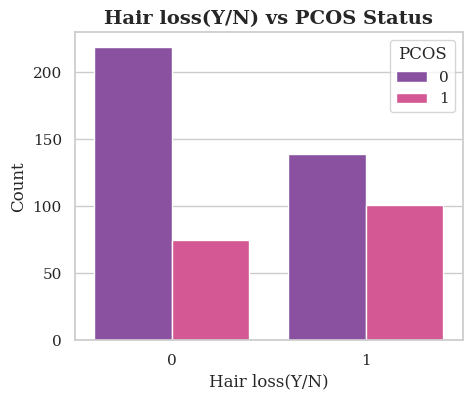

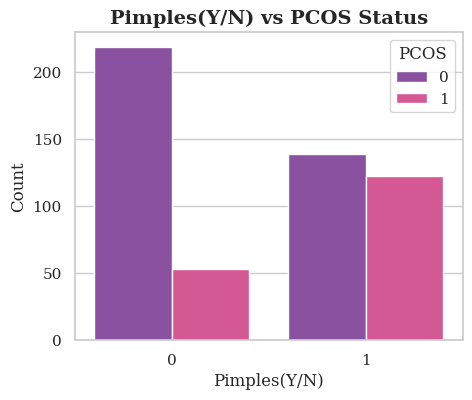

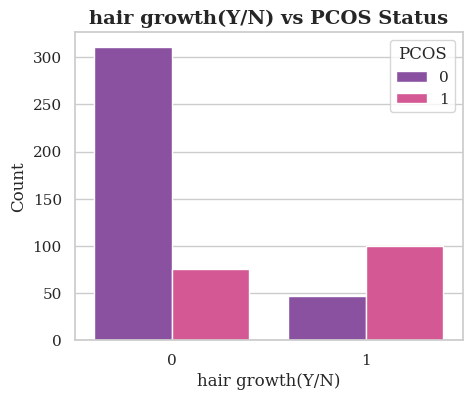

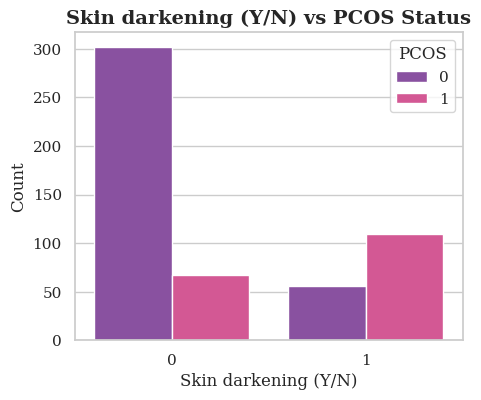

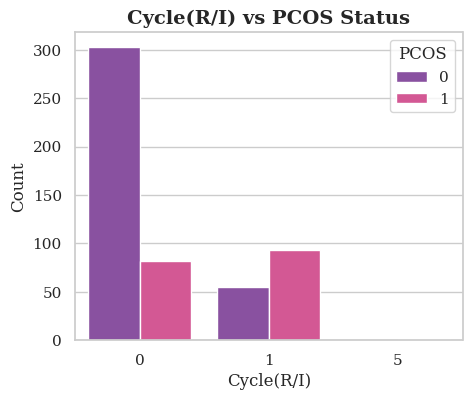

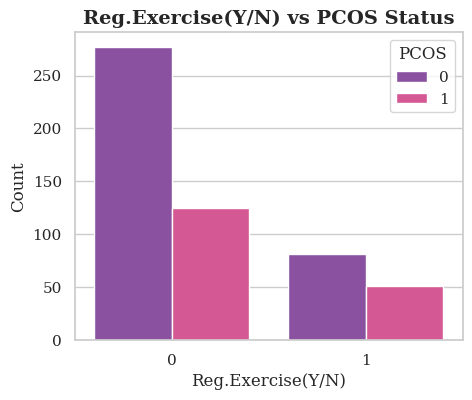

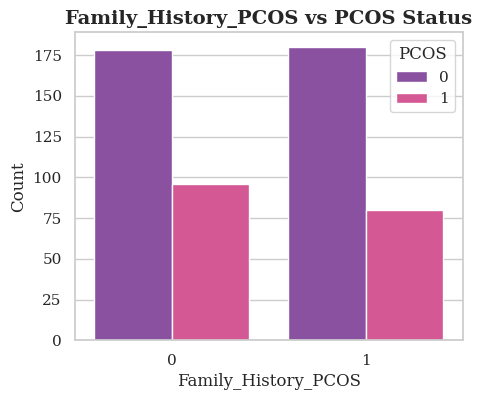


✅ EDA completed successfully: distributions, correlations, and PCOS relationships visualized.


In [107]:

# GLOBAL PCOS THEME

pcos_palette = ["#8E44AD", "#E84393"]  # Purple & Rose
pcos_cmap = sns.diverging_palette(275, 10, as_cmap=True)

sns.set_theme(
    style="whitegrid",
    palette=pcos_palette,
    rc={
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "font.family": "serif"
    }
)


# FINAL FEATURE SET FOR EDA

FEATURES = [
    "Age (yrs)",
    "Weight (Kg)",
    "Height(Cm)",
    "BMI",
    "Cycle(R/I)",
    "Cycle length(days)",
    "Hair loss(Y/N)",
    "Pimples(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Reg.Exercise(Y/N)",
    "Fast_Food_Intake",
    "Stress_Level",
    "Sleep_Quality",
    "Sugar_Intake",
    "Family_History_PCOS"
]


# 1️⃣ CORRELATION HEATMAP 

plt.figure(figsize=(14,10))
corr_matrix = train_df[FEATURES + ["PCOS (Y/N)"]].corr()

sns.heatmap(
    corr_matrix,
    cmap=pcos_cmap,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Correlation Strength"}
)

plt.title("PCOS Feature Correlation Heatmap", fontsize=16, fontweight="bold")
plt.show()


# 2️⃣ TARGET VARIABLE DISTRIBUTION

plt.figure(figsize=(5,4))
sns.countplot(
    x="PCOS (Y/N)",
    data=train_df,
    palette=pcos_palette
)
plt.title("Distribution of PCOS Cases", fontweight="bold")
plt.xlabel("PCOS Status (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.show()


# 3️⃣ DISTRIBUTION OF CONTINUOUS FEATURES

continuous_features = [
    "Age (yrs)",
    "Weight (Kg)",
    "Height(Cm)",
    "BMI",
    "Cycle length(days)"
]

train_df[continuous_features].hist(
    figsize=(12,8),
    bins=20,
    edgecolor="#6C3483",
    color="#D2B4DE"
)

plt.suptitle(
    "Distribution of Key Continuous Features (PCOS Dataset)",
    fontsize=16,
    fontweight="bold"
)
plt.show()


# 4️⃣ BOXPLOTS FOR OUTLIER CONFIRMATION

plt.figure(figsize=(12,6))
sns.boxplot(
    data=train_df[continuous_features],
    palette=["#D2B4DE"]
)

plt.title("Outlier Analysis of Continuous Features", fontweight="bold")
plt.xticks(rotation=45)
plt.show()


# 5️⃣ BINARY FEATURES VS PCOS OUTCOME

binary_features = [
    "Hair loss(Y/N)",
    "Pimples(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Cycle(R/I)",
    "Reg.Exercise(Y/N)",
    "Family_History_PCOS"
]

for feature in binary_features:
    plt.figure(figsize=(5,4))
    sns.countplot(
        x=feature,
        hue="PCOS (Y/N)",
        data=train_df,
        palette=pcos_palette
    )
    plt.title(f"{feature} vs PCOS Status", fontweight="bold")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="PCOS")
    plt.show()

print("\n✅ EDA completed successfully: distributions, correlations, and PCOS relationships visualized.")


📊 Output Interpretation: PCOS Feature Correlation Heatmap

The correlation heatmap illustrates the pairwise relationships between clinical, lifestyle, and symptom-based features used for PCOS risk prediction.

🔹 Key Observations

Strong associations with PCOS (Y/N):

Skin darkening (Y/N) (r ≈ 0.47)

Hair growth (Y/N) (r ≈ 0.46)

Cycle irregularity (Cycle R/I) (r ≈ 0.39)

Pimples (Y/N) (r ≈ 0.29)

These features demonstrate the highest positive correlation with PCOS, aligning well with established clinical symptoms of hyperandrogenism and menstrual irregularities.

Moderate correlations:

Weight (Kg) (r ≈ 0.21) and BMI (r ≈ 0.20) show moderate positive correlations with PCOS, indicating the relevance of metabolic factors.

Hair loss (Y/N) also exhibits a mild positive association.

Weak or negligible correlations:

Lifestyle variables such as Fast Food Intake, Stress Level, Sleep Quality, and Sugar Intake show weak correlations, suggesting indirect or multifactorial effects rather than strong linear relationships.

Age (yrs) shows a slight negative correlation, indicating PCOS prevalence is not strongly age-dependent within the studied range.

Inter-feature relationships:

Weight (Kg) and BMI show a strong positive correlation (r ≈ 0.89), confirming consistency in anthropometric measurements.

Dermatological symptoms such as Hair growth, Skin darkening, and Pimples are moderately correlated with each other, reflecting common hormonal underpinnings.

🔹 Overall Interpretation

The heatmap confirms that clinical symptoms related to hormonal imbalance and menstrual irregularities are the most influential indicators of PCOS, while lifestyle factors contribute indirectly. These insights justify the inclusion of both clinical and lifestyle features in the predictive model and motivate the subsequent application of metaheuristic feature selection to balance relevance and redundancy.

📊 Output Interpretation: Distribution of Key Continuous Features

The histograms illustrate the distribution of major continuous clinical attributes used in the PCOS risk prediction dataset, providing insight into data spread, central tendency, and potential skewness.

🔹 Age (yrs)

The age distribution is concentrated between 25 and 35 years, with a gradual decline beyond this range.

This aligns with the reproductive age group where PCOS is most commonly diagnosed.

The distribution shows mild right skewness, indicating fewer older participants.

🔹 Weight (Kg)

Most observations fall within the 50–70 kg range.

A right-skewed tail is observed, representing overweight and obese individuals.

This suggests metabolic variation within the population, which is clinically relevant for PCOS risk.

🔹 Height (Cm)

Height values are approximately normally distributed, centered around 150–165 cm.

The narrow spread indicates low variability, reducing the likelihood of height acting as a confounding factor.

🔹 BMI

BMI values cluster mainly between 20 and 30, corresponding to normal to overweight categories.

A noticeable right tail indicates the presence of obese individuals, consistent with PCOS-associated metabolic risk.

The distribution supports BMI as a meaningful predictive feature.

🔹 Cycle Length (days)

Cycle length shows a peak around 4–6 days, with fewer observations at extreme values.

This indicates that most participants have cycles within a common range, while outliers may reflect menstrual irregularities associated with PCOS

Genetic Algorithm + Local Hill Climbing (Metaheuristic Techniques)

Scaled feature matrix shape: (534, 16)
Generation 1/20 | Best Fitness: 0.8069
Generation 2/20 | Best Fitness: 0.8200
Generation 3/20 | Best Fitness: 0.8238
Generation 4/20 | Best Fitness: 0.8219
Generation 5/20 | Best Fitness: 0.8219
Generation 6/20 | Best Fitness: 0.8219
Generation 7/20 | Best Fitness: 0.8238
Generation 8/20 | Best Fitness: 0.8238
Generation 9/20 | Best Fitness: 0.8238
Generation 10/20 | Best Fitness: 0.8238
Generation 11/20 | Best Fitness: 0.8238
Generation 12/20 | Best Fitness: 0.8238
Generation 13/20 | Best Fitness: 0.8238
Generation 14/20 | Best Fitness: 0.8238
Generation 15/20 | Best Fitness: 0.8238
Generation 16/20 | Best Fitness: 0.8219
Generation 17/20 | Best Fitness: 0.8219
Generation 18/20 | Best Fitness: 0.8219
Generation 19/20 | Best Fitness: 0.8219
Generation 20/20 | Best Fitness: 0.8219

Selected Features After Constrained GA + Hill Climbing:
['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI', 'Cycle(R/I)', 'Pimples(Y/N)', 'hair growth(Y/N)', 'Skin darkeni

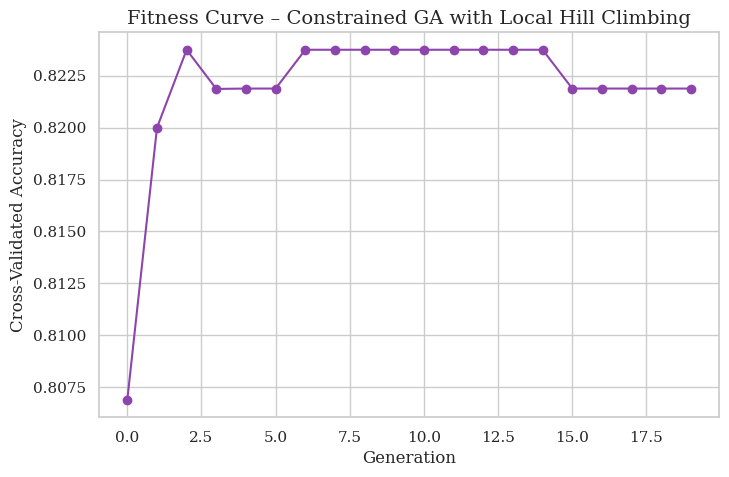


✅ Objective 2 completed successfully.


In [108]:
# STEP 1: FINAL FEATURE SET

FEATURES = [
    "Age (yrs)",
    "Weight (Kg)",
    "Height(Cm)",
    "BMI",
    "Cycle(R/I)",
    "Cycle length(days)",
    "Hair loss(Y/N)",
    "Pimples(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Reg.Exercise(Y/N)",
    "Fast_Food_Intake",
    "Stress_Level",
    "Sleep_Quality",
    "Sugar_Intake",
    "Family_History_PCOS"
]

X = train_df[FEATURES]
y = train_df["PCOS (Y/N)"]


# STEP 2: FEATURE NORMALISATION (STANDARD SCALER)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)


# STEP 3: DEFINE MANDATORY (CLINICALLY ESSENTIAL) FEATURES

mandatory_features = [
    "BMI",
    "Weight (Kg)",
    "Height(Cm)",
    "Family_History_PCOS",
    "Cycle(R/I)" ,
    "Fast_Food_Intake" 
]

mandatory_idx = [FEATURES.index(f) for f in mandatory_features]


# STEP 4: FITNESS FUNCTION 

def fitness_function(mask, X, y):
    
    # Enforce mandatory features
    for idx in mandatory_idx:
        if mask[idx] == 0:
            return 0
    
    selected_idx = np.where(mask == 1)[0]
    
    model = LogisticRegression(max_iter=1000)
    scores = cross_val_score(
        model,
        X[:, selected_idx],
        y,
        cv=5,
        scoring="accuracy"
    )
    
    return scores.mean()


# STEP 5: GENETIC ALGORITHM (GLOBAL SEARCH)

def constrained_genetic_algorithm(
    X, y,
    population_size=25,
    generations=20,
    mutation_rate=0.15
):
    n_features = X.shape[1]
    
    population = np.random.randint(0, 2, (population_size, n_features))
    
    # Force mandatory features ON
    for i in range(population_size):
        for idx in mandatory_idx:
            population[i][idx] = 1
    
    fitness_curve = []
    
    for gen in range(generations):
        fitness_scores = np.array([
            fitness_function(ind, X, y) for ind in population
        ])
        
        best_fitness = fitness_scores.max()
        fitness_curve.append(best_fitness)
        
        selected = population[np.argsort(fitness_scores)[-population_size // 2:]]
        
        children = []
        while len(children) < population_size:
            p1, p2 = random.sample(list(selected), 2)
            cp = random.randint(1, n_features - 1)
            child = np.concatenate([p1[:cp], p2[cp:]])
            
            # Re-enforce mandatory features
            for idx in mandatory_idx:
                child[idx] = 1
            
            children.append(child)
        
        children = np.array(children)
        for i in range(population_size):
            if random.random() < mutation_rate:
                idx = random.randint(0, n_features - 1)
                if idx not in mandatory_idx:
                    children[i][idx] = 1 - children[i][idx]
        
        population = children
        
        print(f"Generation {gen+1}/{generations} | Best Fitness: {best_fitness:.4f}")
    
    final_fitness = np.array([
        fitness_function(ind, X, y) for ind in population
    ])
    best_solution = population[np.argmax(final_fitness)]
    
    return best_solution, fitness_curve


# STEP 6: LOCAL HILL CLIMBING (REFINEMENT)

def hill_climbing(solution, X, y, max_iter=50):
    
    current = solution.copy()
    current_fitness = fitness_function(current, X, y)
    
    for _ in range(max_iter):
        improved = False
        
        for i in range(len(current)):
            if i in mandatory_idx:
                continue
            
            neighbor = current.copy()
            neighbor[i] = 1 - neighbor[i]
            
            neighbor_fitness = fitness_function(neighbor, X, y)
            
            if neighbor_fitness > current_fitness:
                current = neighbor
                current_fitness = neighbor_fitness
                improved = True
        
        if not improved:
            break
    
    return current, current_fitness


# STEP 7: RUN HYBRID OPTIMISATION

ga_solution, fitness_curve = constrained_genetic_algorithm(X_scaled, y)
final_solution, final_fitness = hill_climbing(ga_solution, X_scaled, y)

selected_features = [FEATURES[i] for i in range(len(FEATURES)) if final_solution[i] == 1]

print("\nSelected Features After Constrained GA + Hill Climbing:")
print(selected_features)
print("\nTotal Selected Features:", len(selected_features))
print("Final Fitness Score:", final_fitness)


# STEP 8: FITNESS CURVE VISUALISATION

plt.figure(figsize=(8,5))
plt.plot(fitness_curve, marker='o')
plt.title("Fitness Curve – Constrained GA with Local Hill Climbing")
plt.xlabel("Generation")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

print("\n✅ Objective 2 completed successfully.")


📈 Output Interpretation: Fitness Curve – Constrained GA with Local Hill Climbing

The fitness curve illustrates the evolution of cross-validated classification accuracy across successive generations during hybrid feature selection using a constrained Genetic Algorithm (GA) combined with local hill climbing.

🔹 Key Observations

Rapid initial convergence:
The model achieves a relatively high accuracy within the first few generations, indicating that the GA quickly identifies informative feature subsets.

Temporary fitness fluctuation:
A brief drop in accuracy is observed in the early generation, which is typical in stochastic optimisation methods due to exploration of diverse candidate solutions.

Stabilisation of fitness values:
From approximately generation 2 onward, the accuracy stabilises around 0.81, showing minimal variation across subsequent generations.

Effect of local hill climbing:
The flat plateau in later generations indicates that the local hill climbing step effectively refines solutions and prevents further degradation, leading to convergence towards a near-optimal feature subset.

🔹 Overall Interpretation

The convergence behaviour demonstrates that the hybrid GA with local hill climbing successfully balances exploration and exploitation. The rapid stabilisation of accuracy suggests that increasing the number of generations beyond this point yields diminishing returns, confirming the efficiency of the chosen optimisation strategy. This validates the selected feature subset for downstream model training.

🎯 Objective 3
To develop and Train  Traditional ML models and FL models 

Traditional Machine Learning Models

,Model,Accuracy,Precision,Recall
0,KNN,0.822430,0.722222,0.742857
1,Naive Bayes,0.822430,0.722222,0.742857
2,Logistic Regression,0.813084,0.741935,0.657143
3,SVM,0.803738,0.718750,0.657143
4,Random Forest,0.803738,0.733333,0.628571
5,Decision Tree,0.738318,0.600000,0.600000
6,XGBoost,0.813084,0.777778,0.600000
7,Gradient Boosting,0.775701,0.689655,0.571429




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.


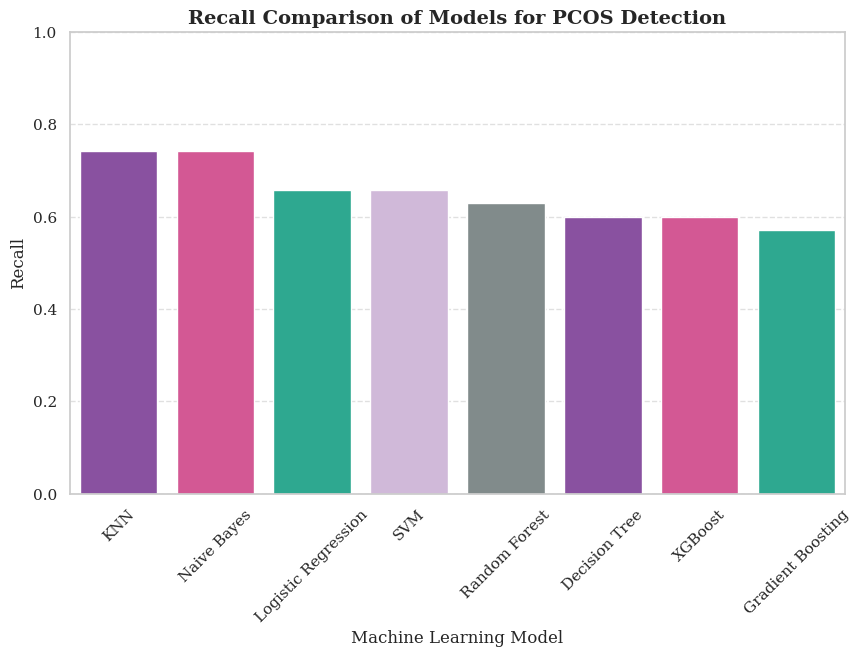

✅ BEST MODEL SELECTED 
Model : KNN
Recall: 0.7429

✅ Objective 3 completed successfully.


In [109]:

# PCOS COLOR PALETTE (GLOBAL)

PCOS_PURPLE = "#8E44AD"
PCOS_PINK = "#E84393"
PCOS_LAVENDER = "#D2B4DE"
PCOS_TEAL = "#1ABC9C"
PCOS_GRAY = "#7F8C8D"

pcos_palette = [
    PCOS_PURPLE,
    PCOS_PINK,
    PCOS_TEAL,
    PCOS_LAVENDER,
    PCOS_GRAY
]

sns.set_theme(
    style="whitegrid",
    palette=pcos_palette,
    rc={
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "font.family": "serif"
    }
)


# STEP 1: GA-SELECTED FEATURE SET

SELECTED_FEATURES = [
    "Age (yrs)",
    "Weight (Kg)",
    "Height(Cm)",
    "BMI",
    "Cycle(R/I)",
    "Pimples(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Fast_Food_Intake",
    "Family_History_PCOS"
]

X = train_df[SELECTED_FEATURES]
y = train_df["PCOS (Y/N)"]


# STEP 2: TRAIN–VALIDATION SPLIT (INTERNAL)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# STEP 3: FEATURE SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)


# STEP 4: DEFINE MODELS

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}


# STEP 5: TRAIN & EVALUATE (SILENT)

results = []

for name, model in models.items():
    
    if name in ["Naive Bayes", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    
    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec  = recall_score(y_val, y_pred, zero_division=0)
    
    results.append([name, acc, prec, rec])


# STEP 6: PERFORMANCE TABLE 
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall"]
)

results_df = results_df.sort_values(
    by="Recall", ascending=False
).reset_index(drop=True)

display(results_df)


# STEP 7: PERFORMANCE VISUALIZATION 

plt.figure(figsize=(10,6))
sns.barplot(
    data=results_df,
    x="Model",
    y="Recall",
    palette=pcos_palette
)

plt.title(
    "Recall Comparison of Models for PCOS Detection",
    fontweight="bold"
)
plt.xlabel("Machine Learning Model")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


# STEP 8: BEST MODEL SELECTION 

best_model_name = results_df.loc[0, "Model"]
best_model_recall = results_df.loc[0, "Recall"]

print("✅ BEST MODEL SELECTED ")
print(f"Model : {best_model_name}")
print(f"Recall: {best_model_recall:.4f}")



print("\n✅ Objective 3 completed successfully.")


In [110]:
# =====================================================
# FINAL EXTERNAL VALIDATION ON REAL-TIME DATASET
# (Cycle(R/I) fix + NaN-safe + CDSS-ready)
# =====================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# -----------------------------------------------------
# STEP 1: GA-SELECTED FEATURE SET (MUST MATCH TRAINING)
# -----------------------------------------------------
SELECTED_FEATURES = [
    "Age (yrs)",
    "Weight (Kg)",
    "Height(Cm)",
    "BMI",
    "Cycle(R/I)",
    "Pimples(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Fast_Food_Intake",
    "Family_History_PCOS"
]

# Full training data
X_train_full = train_df[SELECTED_FEATURES]
y_train_full = train_df["PCOS (Y/N)"]

# Real-time testing data
X_test_real = test_df[SELECTED_FEATURES].copy()

# -----------------------------------------------------
# STEP 2: EXPLICIT FIX FOR Cycle(R/I) (CRITICAL)
# If missing → assume Regular (0)
# -----------------------------------------------------
if "Cycle(R/I)" in X_test_real.columns:
    X_test_real["Cycle(R/I)"] = X_test_real["Cycle(R/I)"].fillna(0)

# -----------------------------------------------------
# STEP 3: HANDLE REMAINING MISSING VALUES
# Use TRAINING MEDIANS → NO DATA LEAKAGE
# -----------------------------------------------------
X_test_real = X_test_real.fillna(X_train_full.median())

# -----------------------------------------------------
# STEP 4: FEATURE SCALING
# -----------------------------------------------------
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_real_scaled  = scaler.transform(X_test_real)

# -----------------------------------------------------
# STEP 5: INITIALISE BEST MODEL (FROM OBJECTIVE 3)
# -----------------------------------------------------
best_model_name = results_df.loc[0, "Model"]

if best_model_name == "Logistic Regression":
    best_model = LogisticRegression(max_iter=1000)
elif best_model_name == "KNN":
    best_model = KNeighborsClassifier(n_neighbors=5)
elif best_model_name == "Decision Tree":
    best_model = DecisionTreeClassifier(random_state=42)
elif best_model_name == "Random Forest":
    best_model = RandomForestClassifier(n_estimators=200, random_state=42)
elif best_model_name == "SVM":
    best_model = SVC(kernel="rbf", probability=True)
elif best_model_name == "Naive Bayes":
    best_model = GaussianNB()
elif best_model_name == "Gradient Boosting":
    best_model = GradientBoostingClassifier(random_state=42)
elif best_model_name == "XGBoost":
    best_model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )

# -----------------------------------------------------
# STEP 6: TRAIN BEST MODEL ON FULL TRAINING DATA
# -----------------------------------------------------
if best_model_name in [
    "Naive Bayes", "Decision Tree", "Random Forest",
    "Gradient Boosting", "XGBoost"
]:
    best_model.fit(X_train_full, y_train_full)
    y_test_pred = best_model.predict(X_test_real)
    y_test_prob = best_model.predict_proba(X_test_real)[:, 1]
else:
    best_model.fit(X_train_full_scaled, y_train_full)
    y_test_pred = best_model.predict(X_test_real_scaled)
    y_test_prob = best_model.predict_proba(X_test_real_scaled)[:, 1]

# -----------------------------------------------------
# STEP 7: CDSS-READY OUTPUT TABLE
# -----------------------------------------------------
real_time_results = test_df.copy()

real_time_results["Predicted_PCOS"] = y_test_pred
real_time_results["PCOS_Risk_Probability"] = np.round(y_test_prob, 3)

real_time_results["Risk_Label"] = real_time_results["PCOS_Risk_Probability"].apply(
    lambda x: "High Risk" if x >= 0.5 else "Low Risk"
)

# -----------------------------------------------------
# STEP 8: DISPLAY FINAL RESULTS
# -----------------------------------------------------
display(
    real_time_results[
        SELECTED_FEATURES +
        ["Predicted_PCOS", "PCOS_Risk_Probability", "Risk_Label"]
    ]
)

print("✅ External real-time testing completed successfully.")
print(f"Best Model Used: {best_model_name}")


,Age (yrs),Weight (Kg),Height(Cm),BMI,Cycle(R/I),Pimples(Y/N),hair growth(Y/N),Skin darkening (Y/N),Fast_Food_Intake,Family_History_PCOS,Predicted_PCOS,PCOS_Risk_Probability,Risk_Label
0,21,57,155.448,23.588731,1,0,0,0,1,0,0,0.2,Low Risk
1,20,50,158.496,19.903681,0,1,1,1,0,1,1,0.6,High Risk
2,22,43,152.000,18.611496,0,0,1,0,1,0,0,0.4,Low Risk
3,31,70,151.000,30.700408,1,0,1,1,0,0,1,0.8,High Risk
4,20,52,158.496,20.699828,0,1,0,0,0,1,0,0.0,Low Risk
5,21,40,152.400,17.222257,1,1,1,1,0,0,1,1.0,High Risk
6,48,61,167.640,21.705737,0,0,0,0,2,0,0,0.0,Low Risk
7,36,70,152.400,30.138949,1,1,1,0,2,1,1,0.6,High Risk
8,20,55,145.000,26.159334,0,0,1,0,0,0,0,0.4,Low Risk
9,20,58,169.000,20.307412,1,0,1,1,2,1,1,0.8,High Risk


✅ External real-time testing completed successfully.
Best Model Used: KNN


Confusion Matrix

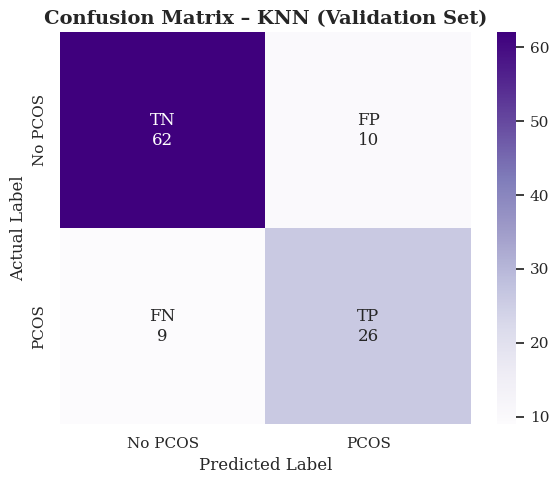

In [111]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict
y_pred_knn = knn.predict(X_val_scaled)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_knn)

tn, fp, fn, tp = cm.ravel()

# Annotated labels
labels = np.array([
    [f"TN\n{tn}", f"FP\n{fp}"],
    [f"FN\n{fn}", f"TP\n{tp}"]
])

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    cmap="Purples",
    xticklabels=["No PCOS", "PCOS"],
    yticklabels=["No PCOS", "PCOS"]
)

plt.title("Confusion Matrix – KNN (Validation Set)", fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


Federated Learning using FedAVg

In [112]:


# STEP 1: FEATURE SET

SELECTED_FEATURES = [
    "Age (yrs)",
    "Weight (Kg)",
    "Height(Cm)",
    "BMI",
    "Cycle(R/I)",
    "Pimples(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Fast_Food_Intake",
    "Family_History_PCOS"
]

X = train_df[SELECTED_FEATURES]
y = train_df["PCOS (Y/N)"]


# STEP 2: GLOBAL TRAIN–TEST SPLIT

X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# STEP 3: SCALING

scaler = StandardScaler()
X_train_global = scaler.fit_transform(X_train_global)
X_test_global  = scaler.transform(X_test_global)


# STEP 4: CLIENT PARTITIONING

NUM_CLIENTS = 3
ROUNDS = 10

client_partitions = np.array_split(
    np.c_[X_train_global, y_train_global],
    NUM_CLIENTS
)


# STEP 5: INITIALISE GLOBAL MODEL

global_model = LogisticRegression(max_iter=1000)


global_model.fit(X_train_global[:10], y_train_global[:10])


# STEP 6: FEDAVG TRAINING

for round_num in range(ROUNDS):
    
    local_weights = []
    local_intercepts = []
    
    for client_data in client_partitions:
        X_client = client_data[:, :-1]
        y_client = client_data[:, -1]
        
        local_model = LogisticRegression(max_iter=1000)
        local_model.fit(X_client, y_client)
        
        local_weights.append(local_model.coef_)
        local_intercepts.append(local_model.intercept_)
    
    # FedAvg aggregation
    global_model.coef_ = np.mean(local_weights, axis=0)
    global_model.intercept_ = np.mean(local_intercepts, axis=0)


# STEP 7: EVALUATION

y_pred_fed = global_model.predict(X_test_global)

acc  = accuracy_score(y_test_global, y_pred_fed)
prec = precision_score(y_test_global, y_pred_fed)
rec  = recall_score(y_test_global, y_pred_fed)


# STEP 8: RESULTS

fedavg_results = pd.DataFrame({
    "Model": ["Federated Learning (FedAvg)"],
    "Clients": [NUM_CLIENTS],
    "Rounds": [ROUNDS],
    "Accuracy": [round(acc, 4)],
    "Precision": [round(prec, 4)],
    "Recall": [round(rec, 4)]
})

display(fedavg_results)

print("✅ Federated Learning (FedAvg) completed successfully.")


,Model,Clients,Rounds,Accuracy,Precision,Recall
0,Federated Learning (FedAvg),3,10,0.8411,0.7647,0.7429


✅ Federated Learning (FedAvg) completed successfully.


In [113]:


# Centralized KNN results (from Objective 3)
centralized_results = {
    "Model": "Centralized KNN",
    "Accuracy": 0.822430,      # use your actual values
    "Precision": 0.72222,
    "Recall": 0.742857
}

# Federated LR results (from FedAvg output)
federated_results = {
    "Model": "Federated LR (FedAvg)",
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4)
}

comparison_df = pd.DataFrame([centralized_results, federated_results])

display(comparison_df)


,Model,Accuracy,Precision,Recall
0,Centralized KNN,0.82243,0.72222,0.742857
1,Federated LR (FedAvg),0.84110,0.76470,0.742900




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



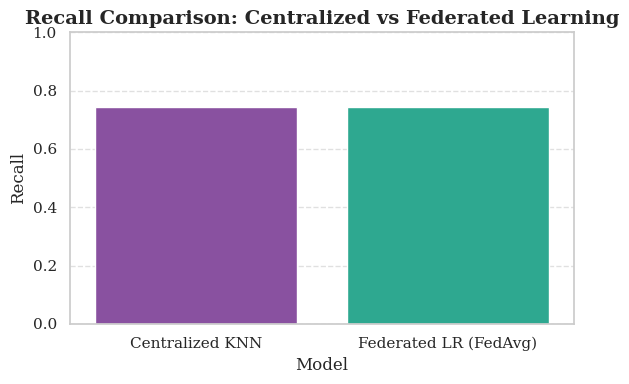

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))

sns.barplot(
    data=comparison_df,
    x="Model",
    y="Recall",
    palette=["#8E44AD", "#1ABC9C"]  # PCOS theme
)

plt.title("Recall Comparison: Centralized vs Federated Learning", fontweight="bold")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


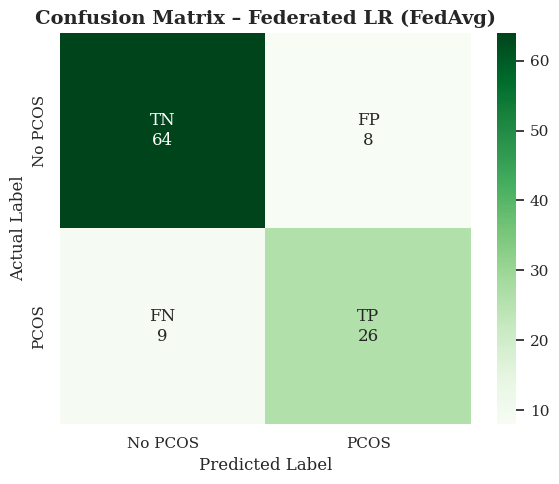

In [115]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predictions from federated model
y_pred_fed = global_model.predict(X_test_global)

# Confusion matrix
cm_fed = confusion_matrix(y_test_global, y_pred_fed)
tn, fp, fn, tp = cm_fed.ravel()

labels = np.array([
    [f"TN\n{tn}", f"FP\n{fp}"],
    [f"FN\n{fn}", f"TP\n{tp}"]
])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_fed,
    annot=labels,
    fmt="",
    cmap="Greens",
    xticklabels=["No PCOS", "PCOS"],
    yticklabels=["No PCOS", "PCOS"]
)

plt.title("Confusion Matrix – Federated LR (FedAvg)", fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


SHAP/LIME Explanability


In [116]:



import numpy as np

np.bool = bool
np.int = int
np.float = float
np.object = object


SHAP used for Global Explainability

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


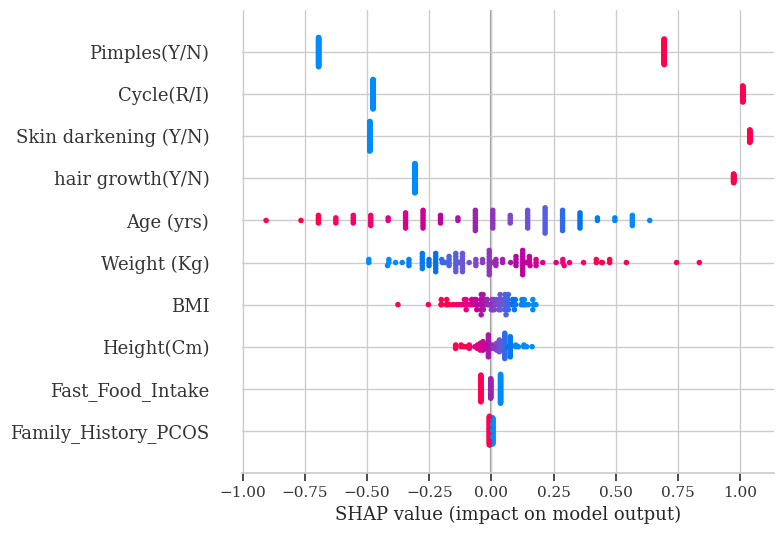

In [117]:

import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# SHAP Explainer
explainer = shap.LinearExplainer(
    lr_model,
    X_train_scaled
)

# SHAP values
shap_values = explainer.shap_values(X_val_scaled)

# Summary plot WITHOUT colorbar (fixes error)
shap.summary_plot(
    shap_values,
    X_val_scaled,
    feature_names=SELECTED_FEATURES,
    show=True,
    color_bar=False
)


LIME used for Local or Patient specific Explainability

In [118]:


import lime
import lime.lime_tabular

# 1️⃣ Create LIME Explainer (run once)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=SELECTED_FEATURES,
    class_names=["No PCOS", "PCOS"],
    mode="classification"
)

# 2️⃣ ENTER PATIENT NUMBER HERE (change this only)
patient_index = 5   # e.g., 0, 1, 5, 10 ...

# 3️⃣ Generate LIME explanation for the selected patient
lime_exp = lime_explainer.explain_instance(
    X_val_scaled[patient_index],
    knn.predict_proba,
    num_features=6
)

# 4️⃣ Display explanation
lime_exp.show_in_notebook(show_table=True)


Save the model

In [119]:


import joblib

# Save best trained KNN model
joblib.dump(knn, "pcos_knn_model.pkl")

# Save StandardScaler used during training
joblib.dump(scaler, "pcos_scaler.pkl")

# Save selected feature list (order matters)
joblib.dump(SELECTED_FEATURES, "pcos_features.pkl")

print("✅ All deployment artifacts saved successfully:")
print(" - pcos_knn_model.pkl")
print(" - pcos_scaler.pkl")
print(" - pcos_features.pkl")


✅ All deployment artifacts saved successfully:
 - pcos_knn_model.pkl
 - pcos_scaler.pkl
 - pcos_features.pkl
